In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 9.3MB/s 


In [3]:
import os,pickle
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras.models import Model,model_from_json,load_model
from keras.layers import Layer,Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
import keras.backend as K

## 数据集预处理
人脸检测->裁剪

In [4]:
# 初始化 MTCNN

mtcnn_detector = MTCNN()

In [5]:
# Fuction of Face Detection and cropping
# 人脸检测和裁剪的方法

def detect_face(image, required_size=(80, 100)):
  
  # detect
	# 检测人脸
	results = mtcnn_detector.detect_faces(image)
 
  # get boundary box
	# 提取人脸区域框
	x1, y1, width, height = results[0]['box']
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height

  # crop
	# 从原图中裁剪出人脸的区域
	face = image[y1:y2, x1:x2]
  
  # resize the faces
	# 调整裁剪区大小
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
 
	return face_array

### 训练集

In [ ]:

# 对训练数据集[{'name':[(array[]),...,(array[])]},...]进行人脸裁剪处理               '/data/train_batch'
# 新的数据集{'labels':[0,0,...,n],'names':['','',...,''],'faces':[(array[]),...,(array[])]}  '/data/train_batch_cropped'

cropped_faces =[]
labels = []
names = []

# your data path
train_path = "drive/My Drive/Face_recognation/train_batch"

with open(train_path, 'rb')as f:
  faces = pickle.load(f)

ID = 0
for one in faces:
  (label,faces_), = one.items()
  # detect face one by one
  # 逐一对数据集中的图片进行人脸检测
  for face in faces_:
    try :
      face_ = detect_face(face)
    except:
      print("error!")
      continue    
    cropped_faces.append(face_)
    labels.append(ID)
    names.append(label)
  ID += 1

labels = np.array (labels)
cropped_faces = np.array(cropped_faces)

In [ ]:
# Save the new dataset to file
# 保存新数据集
train_path_ = "drive/My Drive/Face_recognation/train_batch_cropped"
data={}
data['label'] = labels
data['names'] = names
data['faces'] = cropped_faces
with open(train_path_, 'wb')as f:
  pickle.dump(data,f)

### 测试集

In [ ]:
# 对测试数据集[{'name':(array[])},...]进行人脸裁剪处理                       '/data/test_batch'
# 新的数据集{'labels':[0,0,...,n],'names':['','',...,''],'faces':[(array[]),...,(array[])]}  '/data/test_batch_cropped'

from random import shuffle

cropped_faces =[]
labels = []
names = []

# your data path
test_path = "drive/My Drive/Face_recognation/test_batch_seen"

with open(test_path, 'rb')as f:
  faces = pickle.load(f)

ID = 0
for one in faces:
  (label,face), = one.items()
  print(label)
  try :
    face_ = detect_face(face)
  except:
    print("error!")
    continue    
  cropped_faces.append(face_)
  labels.append(ID)
  names.append(label)
  ID += 1

labels = np.array (labels)
cropped_faces = np.array(cropped_faces)

In [ ]:
print(names[0])

Charles_Taylor


In [ ]:
# Save the new dataset to file
# 保存新数据集
test_path_ = "drive/My Drive/Face_recognation/test_batch_seen_cropped"
data={}
data['label'] = labels
data['names'] = names
data['faces'] = cropped_faces
with open(test_path_, 'wb')as f:
  pickle.dump(data,f)

### triplet test

In [ ]:
# 对用于进行triplet-test的数据集[{'name':(array[])},...]进行人脸裁剪处理            '/data/triplet_test_batch'
# 新的数据集{'labels':[0,0,...,n],'names':['','',...,''],'faces':[(array[]),...,(array[])]}  '/data/triplet_test_batch_cropped'

from random import shuffle

cropped_faces =[]
labels = []
names = []

# your data path
triplet_test_path = "drive/My Drive/Face_recognation/triplet_test"

with open(triplet_test_path, 'rb')as f:
  faces = pickle.load(f)

ID = 0
for one in faces:
  (label,faces_), = one.items()
  # detect face one by one
  # 逐一对数据集中的图片进行人脸检测
  for face in faces_:
    try :
      face_ = detect_face(face)
    except:
      print("error!")
      continue    
    cropped_faces.append(face_)
    labels.append(ID)
    names.append(label)
  ID += 1

labels = np.array (labels)
cropped_faces = np.array(cropped_faces)

In [ ]:
# Save the new dataset to file
# 保存新数据集
triplet_test_path_ = "drive/My Drive/Face_recognation/triplet_test_cropped"
data={}
data['label'] = labels
data['names'] = names
data['faces'] = cropped_faces
with open(triplet_test_path_, 'wb')as f:
  pickle.dump(data,f)

### 构建triplet test数据集

In [ ]:
triplet_test_path = "drive/My Drive/Face_recognation/train_batch_cropped"
with open(triplet_test_path, 'rb')as f:
  data = pickle.load(f)
names = data['names']
labels = data['label']
cropped_faces = data['faces']
del data

In [ ]:
len(labels)/len(np.unique(labels))

6.0

In [ ]:
# Generate a Random Test Batch
def generate_random_triplet(batch_size, numk=6):
  n_IDs = len(cropped_faces)
  X_anchor_samples = np.array([face for face in cropped_faces])
  # 随机选择batch_size个图像作为样本
  filter = np.random.choice(np.array(range(len(X_anchor_samples))),int(batch_size))
  X_anchor_batch = []
  X_positive_samples = []
  X_negative_samples = []

  for i in filter:
    index = int(i/numk)
    X_positives = X_anchor_samples[index*numk:(index+1)*numk]
    X_anchor = X_anchor_samples[i]
    k=np.random.randint(numk)
    while k==i%numk:
      k=np.random.randint(numk)

    X_anchor_batch.append(X_anchor)
    X_positive_samples.append(X_positives[k])

    k2 = np.random.randint(n_IDs)
    while k2>=index*numk and k2<(index+1)*numk+1:
      k2 = np.random.randint(n_IDs)
    X_negative_samples.append(X_anchor_samples[k2])
  
  X_anchor_batch = np.array(X_anchor_batch)
  X_positive_samples = np.array(X_positive_samples)
  X_negative_samples = np.array(X_negative_samples)  

  return [X_anchor_batch,X_positive_samples,X_negative_samples]

In [ ]:
triplet_test_batch = generate_random_triplet(180)

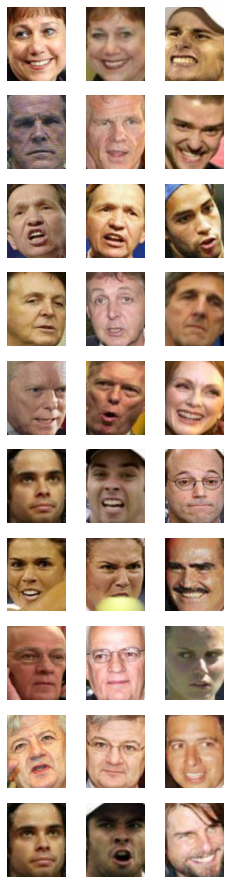

In [ ]:
plt.figure(figsize=(4,16))
for i in range(10):
  plt.subplot(10,3,i*3+1)
  plt.imshow(triplet_test_batch[0][i])
  plt.axis('off')
  plt.subplot(10,3,i*3+2)
  plt.imshow(triplet_test_batch[1][i])
  plt.axis('off')
  plt.subplot(10,3,i*3+3)
  plt.imshow(triplet_test_batch[2][i])
  plt.axis('off')
plt.show()

In [ ]:
triplet_test_path = "drive/My Drive/Face_recognation/triplet_batch"
with open(triplet_test_path, 'wb')as f:
  pickle.dump(triplet_test_batch, f)

### 底片

In [ ]:

# 对训练数据集[{'name':[(array[]),...,(array[])]},...]进行人脸裁剪处理               '/data/train_batch'
# 新的数据集{'labels':[0,0,...,n],'names':['','',...,''],'faces':[(array[]),...,(array[])]}  '/data/train_batch_cropped'

cropped_faces =[]
labels = []
names = []

# your data path
train_path = "drive/My Drive/Face_recognation/train_batch"

with open(train_path, 'rb')as f:
  faces = pickle.load(f)

ID = 0
for one in faces:
  (label,faces_), = one.items()
  # detect face one by one
  # 逐一对数据集中的图片进行人脸检测
  for face in faces_:
    try :
      face_ = detect_face(face)
    except:
      print("error!")
      continue    
    cropped_faces.append(face_)
    labels.append(ID)
    names.append(label)
    break
  ID += 1

labels = np.array (labels)
cropped_faces = np.array(cropped_faces)

In [ ]:
idcards = []
for i in range(len(labels)):
  id_ = {labels[i]: (names[i],cropped_faces[i])}
  idcards.append(id_)

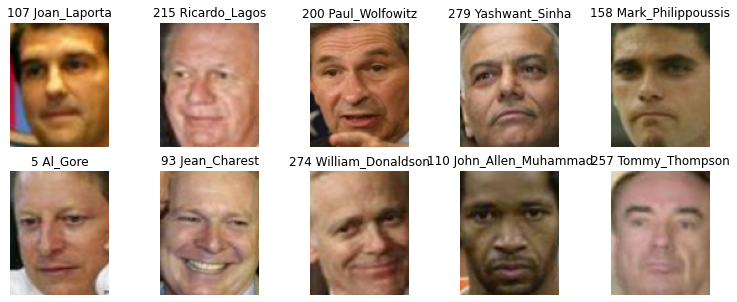

In [ ]:
plt.figure(figsize=(13,5))
for i in range(10):
  index = np.random.randint(283)
  test = idcards[index]
  for k,v in test.items():
    name,face = v
    plt.subplot(2,5,i+1)
    plt.imshow(face)
    plt.axis('off')
    plt.title(str(k)+' '+name)

In [ ]:
card_path = "drive/My Drive/Face_recognation/cards"
with open(card_path, 'wb')as f:
  pickle.dump(idcards, f)

In [ ]:
train_path = "drive/My Drive/Face_recognation/train_batch_cropped"
test_path = "drive/My Drive/Face_recognation/test_batch_seen_cropped"

with open(train_path,'rb') as f:
  train_ = pickle.load(f)
with open(test_path,'rb') as f:
  test_ = pickle.load(f)

In [ ]:
test = {}
test['label'] = test_['label'][:200]
test['names'] = test_['names'][:200]
test['faces'] = test_['faces'][:200]

In [ ]:
test['label'][-10:]

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199])

In [ ]:
with open("drive/My Drive/Face_recognation/test_batch_cropped_200", 'wb')as f:
  pickle.dump(train, f)

In [6]:
test_path = "drive/My Drive/Face_recognation/test_batch_unseen"

cropped_faces =[]
labels = []
names = []

with open(test_path, 'rb')as f:
  faces = pickle.load(f)

ID = 0
for one in faces:
  (label,faces_), = one.items()
  # detect face one by one
  # 逐一对数据集中的图片进行人脸检测
  for face in faces_:
    try :
      face_ = detect_face(face)
    except:
      print("error!")
      continue    
    cropped_faces.append(face_)
    labels.append(ID)
    names.append(label)
  ID += 1

labels = np.array (labels)
cropped_faces = np.array(cropped_faces)

In [7]:
# Save the new dataset to file
# 保存新数据集
testsave_path_ = "drive/My Drive/Face_recognation/test_batch_unseen_cropped"
data={}
data['label'] = labels
data['names'] = names
data['faces'] = cropped_faces
with open(testsave_path_, 'wb')as f:
  pickle.dump(data,f)